In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import functions
from sklearn.base import BaseEstimator,TransformerMixin
from biosppy.signals import ecg
# − _

In [3]:
trainX = pd.read_csv("data/X_train.csv").drop(columns=["id"])
trainy = pd.read_csv("data/y_train.csv").drop(columns=["id"])
testX = pd.read_csv("data/X_test.csv").drop(columns=["id"])

In [4]:
def removeNans(data):
    trainX_aug = []
    for i in tqdm.trange(0,len(data)):
        lastIdx = data.iloc[i].index.get_loc(data.iloc[i,:].last_valid_index())
        trainX_aug.append(data.iloc[i,0:lastIdx])
    trainX_aug = np.array(trainX_aug)
    return trainX_aug

In [5]:
new_trainX = removeNans(trainX)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [05:33<00:00, 15.33it/s]
<ipython-input-4-6cf82b3ee46d>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainX_aug = np.array(trainX_aug)


In [6]:
signals = pd.DataFrame()
for i in tqdm.trange(0,len(new_trainX)):
    signals = signals.append({"ECG_BioSPPy" : nk.ecg_clean(new_trainX[i], sampling_rate=300, method="biosppy")},ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5117/5117 [02:28<00:00, 34.41it/s]


In [8]:
peaks = []
for i in signals["ECG_BioSPPy"].iteritems():
    _, rpeaks = nk.ecg_peaks(i[1], sampling_rate=300)
    peaks.append(rpeaks["ECG_R_Peaks"])

In [ ]:
trainX_sep = []
trainy_sep = []
train = signals["ECG_BioSPPy"].to_frame()

for i in tqdm.trange(0,len(train)):
    for a in range(0,int(len(peaks[i])/4)):
        a *= 4
        if a == 0:
            trainX_sep.append(train.iloc[i][0][:peaks[i][a]])
            trainy_sep.append(trainy["y"][i])
        elif a == len(peaks[i])-1:
            trainX_sep.append(train.iloc[i][0][peaks[i][a]:])
            trainy_sep.append(trainy["y"][i])
        else:
            trainX_sep.append(train.iloc[i][0][peaks[i][a-1]:peaks[i][a]])
            trainy_sep.append(trainy["y"][i])

In [71]:
epochs = nk.ecg_segment(signals.iloc[35,0], rpeaks=peaks[35], sampling_rate=300, show=False)
#print(epochs["3"])
#print(trainy["y"][35])
hrv_indices = nk.hrv_time(peaks[3], sampling_rate=300, show=False)
print(hrv_indices.iloc[0])

HRV_MeanNN      406.615385
HRV_SDNN         70.868845
HRV_SDANN1             NaN
HRV_SDNNI1             NaN
HRV_SDANN2             NaN
HRV_SDNNI2             NaN
HRV_SDANN5             NaN
HRV_SDNNI5             NaN
HRV_RMSSD        94.461191
HRV_SDSD         95.207006
HRV_CVNN          0.174290
HRV_CVSD          0.232311
HRV_MedianNN    383.333333
HRV_MadNN        34.594000
HRV_MCVNN         0.090245
HRV_IQRNN        50.000000
HRV_pNN50        30.769231
HRV_pNN20        60.000000
HRV_HTI           4.333333
HRV_TINN         31.250000
Name: 0, dtype: float64


In [157]:
trainy3 = trainy[trainy["y"] != 3]
cleanedX = signals["ECG_BioSPPy"]
trainX3 = cleanedX[trainy["y"] != 3]
trainX3 = trainX3.to_frame().iloc[:,0]

print(np.array(trainy3["y"]))

[0 0 0 ... 0 0 2]


In [140]:
import biosppy.signals.ecg as ecg

features = []
for i in tqdm.trange(0,len(trainX3)):
    info = ecg.ecg(trainX3.iloc[i], sampling_rate =300, show=False)
    features.append(np.append(np.mean(info[4],axis=0), np.std(info[4],axis=0)))  

100%|██████████████████████████████████████████████████████████████████████████████| 4947/4947 [07:03<00:00, 11.69it/s]


In [141]:
print(len(features))

features = np.array(features)
print(np.isnan(features).sum())
features = np.nan_to_num(features,0)
print(np.isnan(features).sum())

4947
0
0


In [142]:
df_features = pd.DataFrame(features)
df_features.insert(0,"y",trainy3,True)
df_features.corr()["y"].sort_values()

5     -0.025889
4     -0.025812
6     -0.024843
3     -0.024269
7     -0.023196
         ...   
182    0.020947
328    0.021530
326    0.023783
327    0.024877
y      1.000000
Name: y, Length: 361, dtype: float64

In [143]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

classifier = XGBClassifier(eval_metric = 'mlogloss')
scores = cross_val_score(classifier, features, trainy3, scoring = 'f1_micro', cv = 5, verbose=1, n_jobs=-1)

print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.8min


[0.74545455 0.72020202 0.70677452 0.7057634  0.70374115]
0.7163871270848016


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


In [146]:
from sklearn.decomposition import PCA

templateMeans = []
for i in tqdm.trange(0,len(trainX3)):
    info = ecg.ecg(trainX3.iloc[i], sampling_rate =300, show=False)
    templateMeans.append(np.mean(info[4],axis=0))

100%|██████████████████████████████████████████████████████████████████████████████| 4947/4947 [05:27<00:00, 15.10it/s]


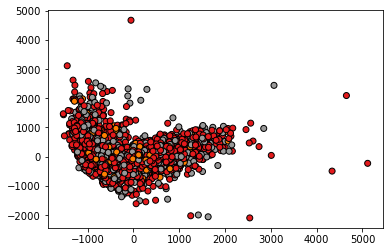

In [160]:
pcaX = PCA(n_components=2).fit_transform(templateMeans)
plt.scatter(pcaX[:,0],pcaX[:,1], c=np.array(trainy3["y"]),cmap=plt.cm.Set1, edgecolor="k")